# Отток клиентов

Из Банка стали уходить клиенты. Каждый месяц. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель с предельно большим значением *F1*-меры.

**Описание данных**

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

**План работы**

1. Изучим и подготовим данные(обработаем пропуски, дубликаты, преобразуем категориальные признаки в численные).
2. Разделим данные на три выборки.
3. Исследуем модели классификации: дерево решений, случайный лес, логистическая регрессия.
4. Подберем лучшие гиперпараметры.
5. Проведем балансировку классов несколькими методами.
5. Проверим лучшую модель на тестовой выборке.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from fast_ml.model_development import train_valid_test_split

## Подготовка данных

In [2]:
df = pd.read_csv('Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
df.Tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Пропуски в столбце Tenure скорее всего означают, что человек является клиентом меньше года. Заменим пропуски на нули.

In [6]:
df.Tenure = df.Tenure.fillna(0)
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.duplicated().sum()

0

Дубликаты не обнаружены.

Столбцы `RowNumber`, `CustomerId`, `Surname` для обучения модели не нужны. Удалим их.

In [8]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


Преобразуем категориальные признаки в численные методом One-Hot Encoding.

In [9]:
df = pd.get_dummies(df, drop_first=True)
df.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0


На данном этапе мы:
- загрузили данные;
- исследовали данные;
- обнаружили пропуски и заполнили их;
- проверили на наличие дубликатов;
- преобразовали категориальные признаки в численные.

## Исследование задачи

Будем решать задачу классификации используя следующие модели:

- Решающее дерево
- Случайный лес
- Логистическая регрессия

Столбец `Exited` это целевой параметр. Будем предсказывать его значение через другие параметры.

Разобьем данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [10]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'Exited',
                                                                            train_size=0.6, valid_size=0.2, 
                                                                            test_size=0.2, random_state=123)

Проверим размер выборок.

In [11]:
display(X_train.shape)
y_train.shape

(6000, 11)

(6000,)

In [12]:
display(X_valid.shape)
y_valid.shape

(2000, 11)

(2000,)

In [13]:
display(X_test.shape)
y_test.shape

(2000, 11)

(2000,)

Рассмотрим баланс классов.

In [14]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Наблюдаем дисбаланс классов. Положительный класс почти в 4 раза меньше отрицательного.

### Масштабирование признаков.

Произведем масштабирование признаков методом стандартизации данных.

In [15]:
X_train.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9696,550,32,8.0,97514.07,1,1,1,199138.84,0,0,1
509,599,37,2.0,0.00,2,1,1,143739.29,0,1,0


In [16]:
# Численные признаки занесем в переменную
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Создание объекта для стандартизации данных
scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])  # Масштабирование обучающего набора данных
X_valid[numeric] = scaler.transform(X_valid[numeric])  # Масштабирование валидационного набора данных
X_test[numeric] = scaler.transform(X_test[numeric])  # Масштабирование тестового набора данных

In [17]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9696,-1.036502,-0.653217,1.116306,0.329383,-0.911674,1,1,1.717588,0,0,1
509,-0.529560,-0.185576,-0.808267,-1.222776,0.799319,1,1,0.758922,0,1,0
621,0.060149,0.095009,1.757830,1.449393,-0.911674,0,1,0.899918,0,1,0
7681,-0.095038,-0.559689,-0.808267,1.104228,0.799319,1,1,-0.762886,0,0,1
4265,0.608474,-0.653217,-0.166743,1.121965,-0.911674,0,1,-1.021335,0,0,1


### Дерево решений.

In [18]:
best_model_tree = None
best_criterion = None
best_result_tree = 0
best_depth = 0

In [19]:
for depth in range(1, 15):
    for criterion in ['gini', 'entropy']:
        model = DecisionTreeClassifier(criterion=criterion, random_state=42, max_depth=depth)
        model.fit(X_train, y_train)  # обучим модель на тренировочных данных
        predictions_valid = model.predict(X_valid)  # найдем предсказания на валидационной выборке
        valid_score = f1_score(y_valid, predictions_valid)

        if valid_score > best_result_tree:
            best_model_tree = model
            best_result_tree = valid_score
            best_depth = depth
            best_criterion = criterion

In [20]:
print('F1_score лучшей модели:', best_result_tree.round(2))
print('Depth лучшей модели:', best_depth)
print('Criterion лучшей модели:', best_criterion)

F1_score лучшей модели: 0.57
Depth лучшей модели: 6
Criterion лучшей модели: entropy


### Случайный лес.

In [21]:
best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est = 0

Сначала подберем глубину леса при небольшом числе деревьев.

In [22]:
%%time
for depth in range(1, 20, 1):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=42)
    model.fit(X_train, y_train)  # обучим модель
    predictions_valid = model.predict(X_valid)
    valid_score = f1_score(y_valid, predictions_valid)
    
    print('Глубина леса:', depth, 'f1_score:', valid_score)
    
    if valid_score > best_result_forest:
        best_result_forest = valid_score
        best_depth_forest = depth
print()        
print('Лучший результат при глубине леса:', best_depth_forest)
print()

Глубина леса: 1 f1_score: 0.0
Глубина леса: 2 f1_score: 0.1367924528301887
Глубина леса: 3 f1_score: 0.29957805907172996
Глубина леса: 4 f1_score: 0.35245901639344257
Глубина леса: 5 f1_score: 0.4835164835164835
Глубина леса: 6 f1_score: 0.494661921708185
Глубина леса: 7 f1_score: 0.5273972602739726
Глубина леса: 8 f1_score: 0.5424292845257904
Глубина леса: 9 f1_score: 0.537704918032787
Глубина леса: 10 f1_score: 0.5602605863192182
Глубина леса: 11 f1_score: 0.5727848101265823
Глубина леса: 12 f1_score: 0.58125
Глубина леса: 13 f1_score: 0.5625
Глубина леса: 14 f1_score: 0.5656877897990726
Глубина леса: 15 f1_score: 0.5591397849462365
Глубина леса: 16 f1_score: 0.5696202531645569
Глубина леса: 17 f1_score: 0.5457413249211357
Глубина леса: 18 f1_score: 0.5754716981132075
Глубина леса: 19 f1_score: 0.546031746031746

Лучший результат при глубине леса: 12

CPU times: total: 4.27 s
Wall time: 4.53 s


Определим количество деревьев с лучшим результатом.

In [23]:
best_result_forest = 0

In [24]:
%%time
for est in range(20, 200, 10):
    model = RandomForestClassifier(n_estimators=est, max_depth=12, random_state=42)
    model.fit(X_train, y_train)  # обучим модель
    predictions_valid = model.predict(X_valid)
    valid_score = f1_score(y_valid, predictions_valid)

    if valid_score > best_result_forest:
        best_model_forest = model  # сохраним наилучшую модель
        best_result_forest = valid_score  # сохраним наилучшее значение f1_score
        best_est = est
    
    print('est', est, 'f1_score', valid_score)
print()
print('F1_score лучшей модели:', best_result_forest.round(2))
print('Количество деревьев лучшей модели:', best_est)
print()

est 20 f1_score 0.58125
est 30 f1_score 0.5830721003134797
est 40 f1_score 0.5727848101265823
est 50 f1_score 0.5687203791469194
est 60 f1_score 0.5596184419713832
est 70 f1_score 0.5636942675159236
est 80 f1_score 0.5650793650793652
est 90 f1_score 0.5668789808917197
est 100 f1_score 0.5705229793977813
est 110 f1_score 0.5668789808917197
est 120 f1_score 0.5723370429252782
est 130 f1_score 0.5727848101265823
est 140 f1_score 0.5727848101265823
est 150 f1_score 0.5691573926868044
est 160 f1_score 0.5700636942675159
est 170 f1_score 0.5645933014354066
est 180 f1_score 0.5700636942675159
est 190 f1_score 0.5691573926868044

F1_score лучшей модели: 0.58
Количество деревьев лучшей модели: 30

CPU times: total: 25.5 s
Wall time: 26.7 s


### Логистическая регрессия

In [25]:
best_model_reg = None
best_result_reg = 0
best_max_iter = 0

In [26]:
%%time
for max_iter in range(50, 1000, 50):
    model = LogisticRegression(random_state=42, solver='liblinear', max_iter=max_iter)  # создадим модель
    model.fit(X_train, y_train)
    predictons_valid = model.predict(X_valid)
    regression_score = f1_score(y_valid, predictions_valid)
        
    if regression_score > best_result_reg:
        best_model_reg = model
        best_result_reg = regression_score
        best_max_iter = max_iter
    print('iter', max_iter, 'f1_score', regression_score)
print()
print('F1_score лучшей модели:', best_result_reg.round(2))
print('Количество итераций лучшей модели:', best_max_iter)
print()

iter 50 f1_score 0.5691573926868044
iter 100 f1_score 0.5691573926868044
iter 150 f1_score 0.5691573926868044
iter 200 f1_score 0.5691573926868044
iter 250 f1_score 0.5691573926868044
iter 300 f1_score 0.5691573926868044
iter 350 f1_score 0.5691573926868044
iter 400 f1_score 0.5691573926868044
iter 450 f1_score 0.5691573926868044
iter 500 f1_score 0.5691573926868044
iter 550 f1_score 0.5691573926868044
iter 600 f1_score 0.5691573926868044
iter 650 f1_score 0.5691573926868044
iter 700 f1_score 0.5691573926868044
iter 750 f1_score 0.5691573926868044
iter 800 f1_score 0.5691573926868044
iter 850 f1_score 0.5691573926868044
iter 900 f1_score 0.5691573926868044
iter 950 f1_score 0.5691573926868044

F1_score лучшей модели: 0.57
Количество итераций лучшей модели: 50

CPU times: total: 359 ms
Wall time: 375 ms


### ROC-кривая

Построим ROC-кривую для трех моделей.

auc_roc Решающее дерево : 0.84
auc_roc Случайный лес : 0.86
auc_roc Логистическая регрессия : 0.75


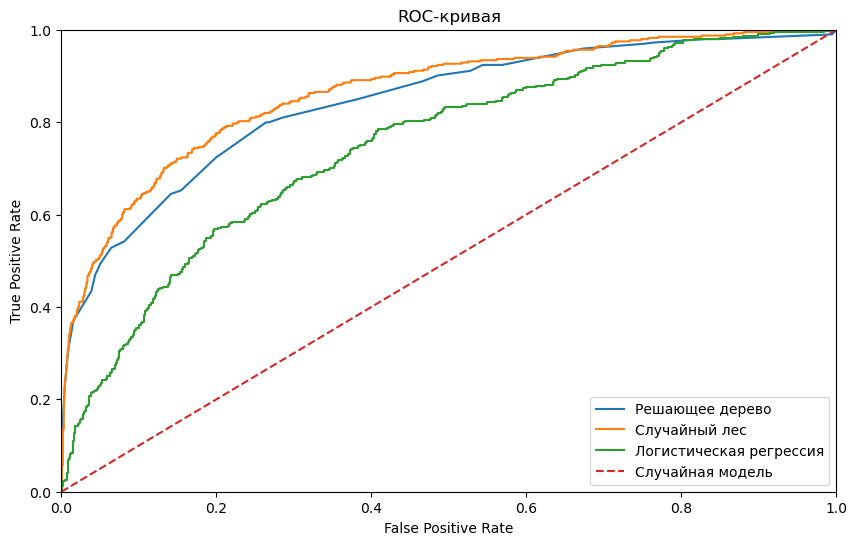

In [27]:
plt.figure(figsize=(10, 6))

def get_plot(model, X_valid, y_valid, label):
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(y_valid, probabilities_one_valid).round(2)  # auc_roc решающего дерева
    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
    print('auc_roc', label, ':', auc_roc)
    return plt.plot(fpr, tpr, label=label)

get_plot(best_model_tree, X_valid, y_valid, 'Решающее дерево')
get_plot(best_model_forest, X_valid, y_valid, 'Случайный лес')
get_plot(best_model_reg, X_valid, y_valid, 'Логистическая регрессия')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.legend()

plt.show()

**Вывод**

На данном шаге мы рассмотрели метрики f1_score и aur_roc для несбалансированных данных и получили слудующие значения:

- Решающее дерево: f1_score = 0.57, auc_roc = 0.84
- Случайный лес: f1_score = 0.58, auc_roc = 0.86
- Логистическая регрессия: f1_score = 0.57, auc_roc = 0.75

## Борьба с дисбалансом

### Взвешивание классов

Дадим больший вес классу "1" при помощи гиперпараметра `class_weight` и рассмотрим как это повлияет на значение F1-меры.

Решающее дерево.

In [28]:
# Решающее дерево
model = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6, class_weight='balanced')
model.fit(X_train, y_train)  # обучим модель на тренировочных данных
predictions_valid = model.predict(X_valid)  # найдем предсказания на валидационной выборке
valid_score = f1_score(y_valid, predictions_valid)
print('F1 решающего дерева:', valid_score.round(2))

F1 решающего дерева: 0.56


Случайный лес.

In [29]:
model = RandomForestClassifier(n_estimators=30, max_depth=12, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)  # обучим модель
predictions_valid = model.predict(X_valid)
valid_score = f1_score(y_valid, predictions_valid)
print('F1 случайного леса:', valid_score.round(2))

F1 случайного леса: 0.6


Логистическая регрессия.

In [30]:
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=50, class_weight='balanced')
model.fit(X_train, y_train)
predictons_valid = model.predict(X_valid)
regression_score = f1_score(y_valid, predictions_valid)
print('F1 логистической регрессии:', valid_score.round(2))

F1 логистической регрессии: 0.6


Взвешивание классов слабо повлияло на значение F1-меры. У решающего дерева значение уменьшилось на 0.1. Значение F1 у случайного леса осталось без изменений. У модели логистической регрессии значение увеличилось на 0.1.

### Увеличение выборки.

Скопируем несколько раз положительные объекты и добавим их в тренировочную выборку.

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)  # перемешаем
    
    return X_upsampled, y_upsampled

X_upsampled, y_upsampled = upsample(X_train, y_train, 4)  # положительный класс отличается в 4 раза
print(y_upsampled.value_counts())  # сравним классы

1    4956
0    4761
Name: Exited, dtype: int64


Обучим модели на сбалансированных данных.

Решающее дерево.

In [32]:
# Решающее дерево
model = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
model.fit(X_upsampled, y_upsampled)  # обучим модель на тренировочных данных
predictions_valid = model.predict(X_valid)  # найдем предсказания на валидационной выборке
valid_score = f1_score(y_valid, predictions_valid)
print('F1 решающего дерева:', valid_score.round(2))

F1 решающего дерева: 0.56


Случайный лес

In [33]:
model = RandomForestClassifier(n_estimators=30, max_depth=12, random_state=42)
model.fit(X_upsampled, y_upsampled)  # обучим модель
predictions_valid = model.predict(X_valid)
valid_score = f1_score(y_valid, predictions_valid)
print('F1 случайного леса:', valid_score.round(2))

F1 случайного леса: 0.61


Логистическая регрессия.

In [34]:
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=50)
model.fit(X_upsampled, y_upsampled)
predictons_valid = model.predict(X_valid)
regression_score = f1_score(y_valid, predictions_valid)
print('F1 логистической регрессии:', valid_score.round(2))

F1 логистической регрессии: 0.61


Увеличением выборки мы добились улучшения F1-меры для модели случайного леса и логистической регрессии.

### Уменьшение выборки.

Случайным образом отбросим часть из отрицательных объектов.

In [35]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    X_downsampled, y_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

X_downsampled, y_downsampled = downsample(X_train, y_train, 0.25)  # возьмем четвертую часть от отриц. объектов

Обучим модели на сбалансированных данных.

Решающее дерево.

In [36]:
# Решающее дерево
model = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
model.fit(X_downsampled, y_downsampled)  # обучим модель на тренировочных данных
predictions_valid = model.predict(X_valid)  # найдем предсказания на валидационной выборке
valid_score = f1_score(y_valid, predictions_valid)
print('F1 решающего дерева:', valid_score.round(2))

F1 решающего дерева: 0.53


Случайный лес

In [37]:
model = RandomForestClassifier(n_estimators=30, max_depth=12, random_state=42)
model.fit(X_downsampled, y_downsampled)  # обучим модель
predictions_valid = model.predict(X_valid)
valid_score = f1_score(y_valid, predictions_valid)
print('F1 случайного леса:', valid_score.round(2))

F1 случайного леса: 0.6


Логистическая регрессия.

In [38]:
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=50)
model.fit(X_downsampled, y_downsampled)
predictons_valid = model.predict(X_valid)
regression_score = f1_score(y_valid, predictions_valid)
print('F1 логистической регрессии:', valid_score.round(2))

F1 логистической регрессии: 0.6


Уменьшением отрицательного класса мы добились улучшения F1-меры для модели случайного леса и логистической регрессии.

**Вывод**

Увеличением выборки мы достигли лучшего показателя F1-меры у случайного леса и логистической регрессии.

### ROC-кривая для сбалансированных классов.

Построим ROC-кривую и посчитаем auc_roc после балансировки классов.

auc_roc Решающее дерево : 0.84
auc_roc Случайный лес : 0.86
auc_roc Логистическая регрессия : 0.75


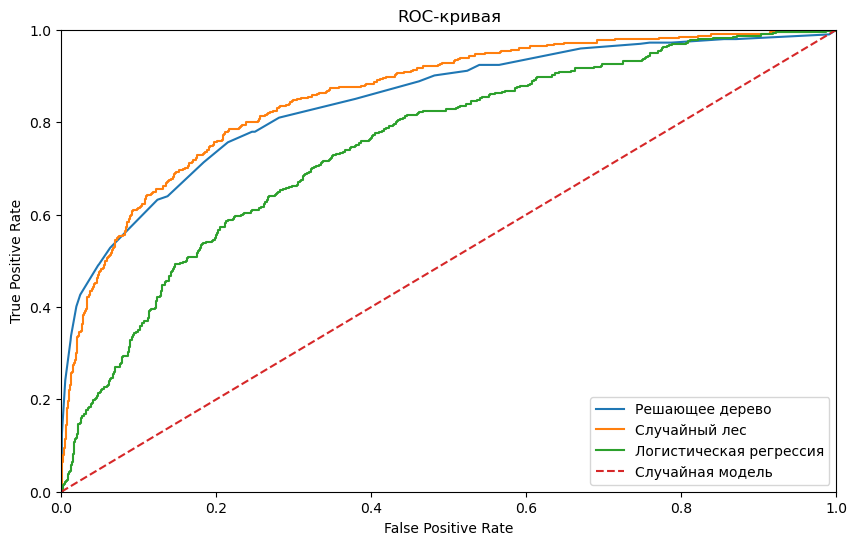

In [39]:
plt.figure(figsize=(10, 6))

def get_plot_balanced(model, X_upsampled, y_upsampled, X_valid, y_valid, label):
    model.fit(X_upsampled, y_upsampled)
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(y_valid, probabilities_one_valid).round(2)  # auc_roc решающего дерева
    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
    print('auc_roc', label, ':', auc_roc)
    return plt.plot(fpr, tpr, label=label)

get_plot_balanced(best_model_tree, X_upsampled, y_upsampled, X_valid, y_valid, 'Решающее дерево')
get_plot_balanced(best_model_forest, X_upsampled, y_upsampled, X_valid, y_valid, 'Случайный лес')
get_plot_balanced(best_model_reg, X_upsampled, y_upsampled, X_valid, y_valid, 'Логистическая регрессия')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.legend()

plt.show()

Значения метрики roc_auc не изменилось полсе балансировки классов.

**Вывод**

При балансе классов модели случайного леса и логистической регрессии точнее предсказывают вероятность ухода клиента банка.
Примем за лучшую модель - модель случайного леса.

Значения f1_score и auc_roc для сбалансированных классов методом увеличения выборки:

- Решающее дерево: f1_score = 0.56, auc_roc = 0.84
- Случайный лес: f1_score = 0.61, auc_roc = 0.86
- Логистическая регрессия: f1_score = 0.61, auc_roc = 0.75

## Тестирование модели

Протестируем модель случайного леса на тестовой выборке.

In [40]:
model = RandomForestClassifier(n_estimators=30, max_depth=12, random_state=42)
model.fit(X_upsampled, y_upsampled)
predictions_test = model.predict(X_test)
result_test = f1_score(y_test, predictions_test)
print('F1 модели случайного леса для тестовой выборки:', result_test.round(2))

probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
print('auc_roc случайного леса для тестовой выборки:', roc_auc_score(y_test, probabilities_one_test).round(2))

F1 модели случайного леса для тестовой выборки: 0.62
auc_roc случайного леса для тестовой выборки: 0.86


Мы проверили качество нашей модели на тестовых данных и получили значение F1-меры лучше чем на валидационных данных.

### Важность признаков

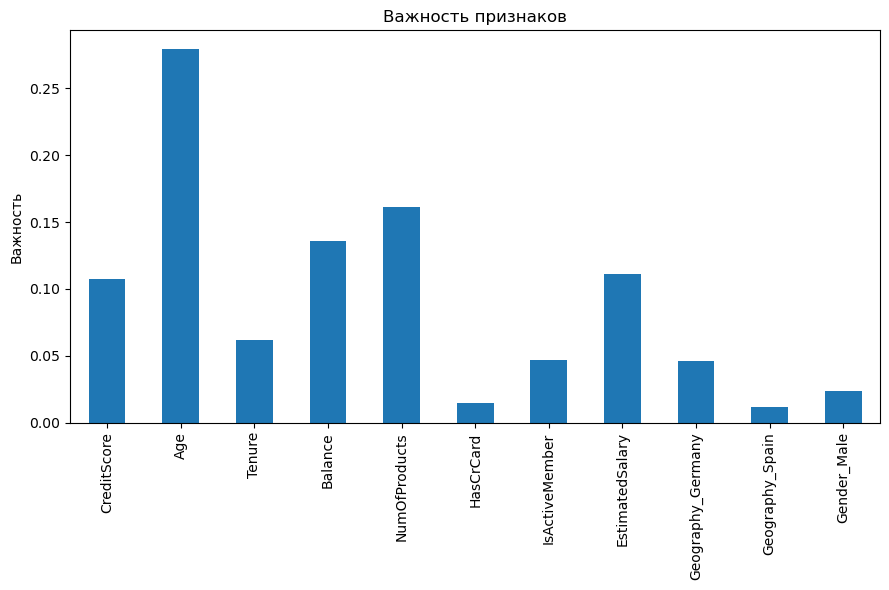

In [41]:
bank_imp = pd.Series(best_model_forest.feature_importances_,
                         X_train.columns)

fig, ax = plt.subplots(figsize=(9,6))
bank_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Наша модель случайного леса отбирает как наиболее важные признаки возраст, количество продуктов и баланс счета. А вот наличие кредитной карты, география и пол оказались не так важны.

##  Вывод.

В данном проекте мы выполнили следующие этапы:

1. Изучили датасет с данными и произвели подготовку(заполнили пропуски, проверили на наличие дубликатов, преобразовали категориальные признаки в численные, произвели масштабирование численных признаков).
2. Разбили данные на три выборки: обучающую, валидационную и тестовую в соотношении 3:1:1.
3. Исследовали три модели: дерево решений, случайный лес, логистическая регрессия.
4. Определили лучшие гиперпараметры.
5. Обучили модели на сбалансированных данных.
5. Проверили качество лучшей модели (случайный лес) на тестовых данных.

Модель случайного леса показала следующие метрики на тестовых данных: f1_score = 0.62, auc_roc = 0.86